# Final Exercise overview
The final exercise will comprise a bunch of mini-projects, together which will approximate a set of analysis tasks required during an emergency response.

The tasks will be categorized into different response functions, loosely according to the Incident Command Structure. We will initially put people into groups based on their interests, just to make sure every task has some people working on it, but people are free to move between tasks as needed. Be sure to communicate amongst the tasks to let each other know when you could use more people or have downtime and can offer help to others.

### Grid
First, we will go over the game grid.

In [99]:
# install and import dependencies
!pip install dwave_networkx
!pip install vrpy
import geopandas as gpd
import numpy as np
import dimod
import networkx as nx
import pandas as pd
import dwave_networkx as dnx
import seaborn as sns
import pickle
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
from vrpy import VehicleRoutingProblem

     |████████████████████████████████| 81 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 4.7 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 40.6 MB 682 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for amply: filename=amply-0.1.2-py3-none-any.whl size=16572 sha256=261e018639d219a6e0b6519ffa76774ed6afee3788ebda866a2f8c2a2da6a253
  Stored in directory: /home/jovyan/.cache/pip/wheels/79/c3/09/0048ee46d04fd5b56f7e3bead9dcef92b2443e529e1f932e6b
Successfully built amply


In [2]:
game_grid = gpd.read_file('grid/game_grid_all_stats.shp')
game_grid.crs = 'epsg:3857'
game_grid

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry
0,19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,10,7,3,15.0,0.2113,"POLYGON ((-7991033.712 5311179.522, -7992397.7..."
1,19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,10,7,3,11.0,0.2113,"POLYGON ((-7989669.690 5311224.829, -7991033.7..."
2,19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,10,7,3,14.0,0.2113,"POLYGON ((-7988305.646 5311269.937, -7989669.6..."
3,19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,10,7,3,21.0,0.2113,"POLYGON ((-7986941.582 5311314.845, -7988305.6..."
4,19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,10,7,3,28.0,0.0336,"POLYGON ((-7985577.497 5311359.555, -7986941.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,10,5,3,0.0,0.0495,"POLYGON ((-7791827.195 5093415.199, -7793161.7..."
15886,19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,10,5,3,0.0,0.0495,"POLYGON ((-7790492.658 5093430.539, -7791827.1..."
15887,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,10,5,3,0.0,0.0495,"POLYGON ((-7793146.168 5092060.201, -7794480.5..."
15888,19TDF1699,DF,19T,416000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.001099,41.542803,10,5,3,0.0,0.0495,"POLYGON ((-7791811.823 5092075.720, -7793146.1..."


In [3]:
game_grid.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The game grid uses the [Military Grid Reference System (MGRS)](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) which breaks the world up into 1-km square cells. The MGRS column is an alphanumeric code which uniquely refers to each of those cells.

Each cell has some important attributes:
- Population: how many people live in that cell
- Health: Average health (higher better)
- Utility: Average access to utilities (higher better)
- Transport: How easy is it to move through the cell (higher better)
- SVI: Social Vulnerability Index
 

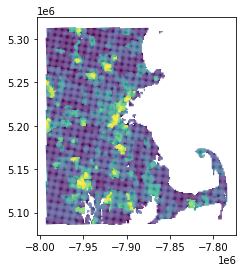

In [4]:
game_grid.plot('SVI')

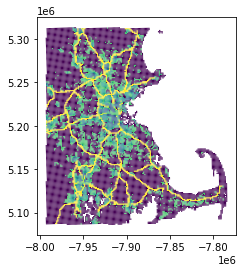

In [5]:
game_grid.plot('Transport')

### Facilities
There are also a number of facilities shapefiles in the `facilities` folders which will be used for a number of the mini-projects.
- airfields: places where airplanes and helicopters can be flown in/from
- cell_towers: communications infrastructure
- EMS: ambulance services
- fire_stations: fire services
- hospitals: hospitals
- local_eocs: local emergency operations centers
- powerplants: energy generating facilities
- shelters: places where people can be tended to
- state_eocs: state emergency operatins centers

In [6]:
airfields = gpd.read_file('facilities/airfields.shp')
airfields.crs = 'epsg:3857'

In [7]:
airfields

,objectid,facilityty,stateabbv,city,geometry
0,7516,Heliport,MA,Barnstable,POINT Z (-70.41530 41.61150 0.00000)
1,7519,Airport,MA,Bedford,POINT Z (-71.28900 42.46994 0.00000)
2,7522,Airport,MA,Berkley,POINT Z (-71.02647 41.83906 0.00000)
3,7523,Seaplane Base,MA,Berkley,POINT Z (-71.11472 41.82056 0.00000)
4,7524,Airport,MA,Berlin,POINT Z (-71.64173 42.36759 0.00000)
...,...,...,...,...,...
139,14668,Heliport,RI,Wakefield,POINT Z (-71.49589 41.43094 0.00000)
140,14669,Heliport,RI,Warwick,POINT Z (-71.47700 41.70538 0.00000)
141,14672,Airport,RI,West Kingston,POINT Z (-71.62064 41.48950 0.00000)
142,14673,Heliport,RI,West Kingston,POINT Z (-71.55617 41.49455 0.00000)


In [55]:
game_grid

,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry,EAST,NORTH,FLOOD_RISK,RISK
MGRS,,,,,,,,,,,,,,,,,,,,
19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,10,7,3,15.0,0.2113,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",272,4764,0.000000,0.100000
19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,10,7,3,11.0,0.2113,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",273,4764,0.006861,0.101305
19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,10,7,3,14.0,0.2113,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",274,4764,0.013708,0.102607
19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,10,7,3,21.0,0.2113,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",275,4764,0.020540,0.103906
19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,10,7,3,28.0,0.0336,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",276,4764,0.027359,0.100827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,10,5,3,0.0,0.0495,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",416,4600,0.928756,0.141376
19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,10,5,3,0.0,0.0495,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",417,4600,0.922512,0.141098
19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,10,5,3,0.0,0.0495,"POLYGON ((-0.00000 0.00000, -0.00000 0.00000, ...",415,4599,0.938385,0.141805


In [9]:
game_grid_plot = game_grid.copy()
game_grid_plot['geometry'] = gpd.points_from_xy(game_grid['x_centroid'],game_grid['y_centroid'])

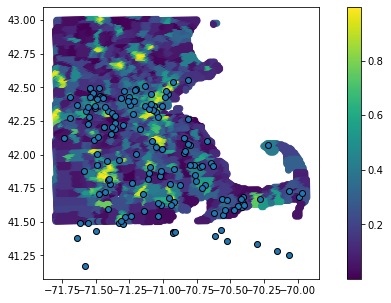

In [10]:
import contextily as ctx
axsvi = airfields.plot(figsize=(10,5), alpha=1, edgecolor='k', zorder = 10)
game_grid_plot.plot('SVI', ax=axsvi, figsize=(10,5), zorder = 0, legend = True)

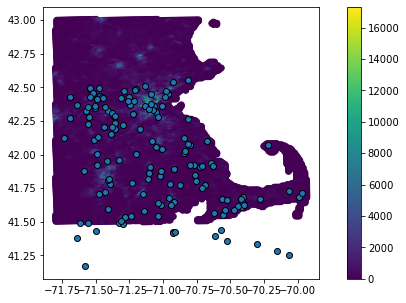

In [11]:
axpop = airfields.plot(figsize=(10,5), alpha=1, edgecolor='k', zorder = 10)
game_grid_plot.plot('population', ax=axpop, figsize=(10,5), zorder = 0, legend = True)

# TASKS
## Planning
### Projection
Build a projection of the storm surge using a DEM of the area and a bathtub filling model. Build projections for different storm surge levels between 1m - 10m. Build a tool that would allow you to compute storm surge levels based on forecasted hurricane size and path (storm surge will be higher near the center of the hurricane than far away, stronger hurricanes will have larger effects).

### Evacuation Zones
Create vectors to represent 3 evacuation zones based on your storm surge projections. Zone A will be evacuated first, B second, C third. 

Consider how many people are in each evacuation zone, and where you will evacuate them to. Inside the `facilities` folder, there is a shapefile of shelters which may be useful for you. You may also use the internet to find other facilities which may not be on the list which may be used as shelters as well.

Document the reasoning behind your choices.

### Shelter activation
Assume each shelter can house up to 500 people. How many shelters will you need to prepare for your evacuations? Which shelters will you send people to? Assume 80% compliance on the evacuation orders (80% of people will comply with evacuation), and 50% of the evacuated will need shelter (assume other 50% have other places to stay)

In [12]:
shelters = gpd.read_file('facilities/shelters.shp')
shelters

,ID,NAME,ADDRESS,CITY,STATE,ZIP,geometry
0,440053,CHARIHO HIGH SCHOOL,453 SWITCH RD,WOOD RIVER JUNCTION,RI,02894,POINT Z (-71.69645 41.45008 0.00000)
1,250058,PLYMOUTH MEMORIAL HALL,83 COURT ST,PLYMOUTH,MA,02360,POINT Z (-70.66869 41.95994 0.00000)
2,440080,WESTERN HILLS MIDDLE SCHOOL,400 PHENIX AVE,CRANSTON,RI,02920,POINT Z (-71.47714 41.77518 0.00000)
3,440143,POLICE COMMUNITY ROOM,4901 OLD POST ROAD,CHARLESTOWN,RI,02813,POINT Z (-71.66757 41.37474 0.00000)
4,251067,BEDFORD HIGH SCHOOL,9 MUDGE WAY,BEDFORD,MA,01730,POINT Z (-71.28554 42.49140 0.00000)
...,...,...,...,...,...,...,...
787,250847,FIRE STATION 6,962 HAMMOND ST,CHESTNUT HILL,MA,02467,POINT Z (-71.16347 42.31167 0.00000)
788,251026,VETERAN'S MEMORIAL ELEMENTARY SCHOOL,39 HURD AVE,SAUGUS,MA,01906,POINT Z (-71.00399 42.45417 0.00000)
789,250524,SHELBURNE COMMUNITY CENTER,2730 WASHINGTON ST,BOSTON,MA,02119,POINT Z (-71.09033 42.32234 0.00000)
790,250161,ESTEN ELEMENTARY SCHOOL,733 SUMMER ST,ROCKLAND,MA,02370,POINT Z (-70.89703 42.11026 0.00000)


# Operations team
## Situational Awareness
### Deep Learning Classifier
Using the LADI dataset, create a tool that can detect multiple types of damage, and multiple types of infrastructure. Possible considerations and enhancements:
- Multi-label classification
- Performance characterization: ROC or PR curves, Confusion Matrices
- Optimizations for training
- Object localization (you may need to create additional training data for this)

### CAP Image Localization tool
Enhance the CAP image localization tool to improve the localization performance. Potential enhancements:
- Using DEM to adjust for elevation and non-levelness of terrain
- Automatically incorporating other data sources, such as satellite, for additional context
- Using the CAP image footprint and OSM, get the roads, buildings, airports, etc which appear inside the CAP image

### Deploy/Implement xView2
Run one of the xView2 solutions from https://github.com/DIUx-xView
Evaluate the performance, generate a report with demonstrations. If you'd like, you can attempt to to improve or modify their solutions (outside of the scope of the class).

# Logistics
## Routing and Resource Management
### Asset deployment
You have access to 1 helicopter, 20 tractor-trailer trucks, and 20 pickup trucks. You can set up a base at any of the airfields of your choice. You can have up to 2 bases. Where do you place your assets?
- helicopter: cost \$1000/hr to operate, 250 km/hr speed - air, capacity: 2
- tractor-trailer: cost \$50/hr to operate, 100 km/hr speed - land, capacity: 20
- pickup truck: cost \$20/hr to operate, 120 km/hr speed - land, capacity: 3

### Game grid to network conversion
Convert the game grid gdf to a `networkx` object where each cell of the grid is a node, and it is connected to each of its adjacent nodes by an edge. The edge weight between node `node_i` and its neighbor `node_j` is given by the pseudocode formula:
`weight_ij = (5/2)*((1/node_i.transport) + (1/node_j.transport))`

where `node_i.transport` is the transport score of the cell `i`. The travel time across edge `ij` is given by `weight_ij*(120/speed_in_kmh)` minutes.

The helicopter flies straight line to its targets and ignores the network weights.

### Vehicle Routing Problem
You will be given lists of facilities (from the ones in `facilities/`) you need to deliver supplies to. Create a tool to compute the routes you would take and the vehicles you would use in order to get the supplies to those facilities. The vehicles must begin and end their trip at one of your bases, but they do not necessarily need to end at the same one they began at. You will be given a budget and time frame, and you want to deliver as many supplies as possible to those facilities within your time frame and budget. 

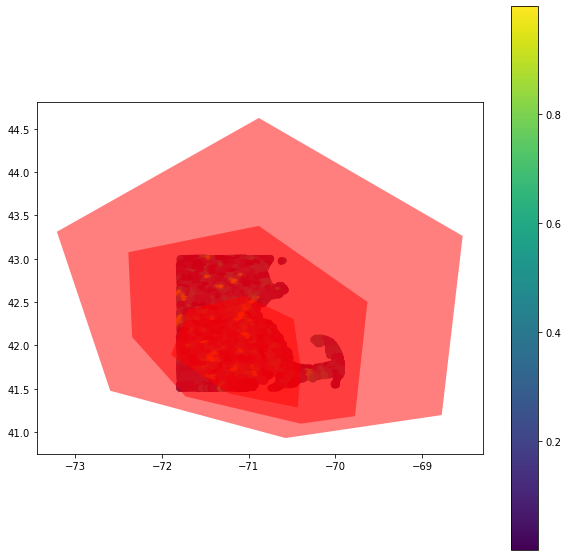

In [13]:
speeds = 'wind_speed_update.geojson'
speeds = gpd.read_file(speeds)
ax = speeds.plot(figsize=(10, 10), color='red', alpha = 0.5)
game_grid_plot.plot('SVI', ax=ax, figsize=(10,10), zorder = 0, legend = True) #Plot Social Vulnerability Index

In [14]:
### Asset deployment

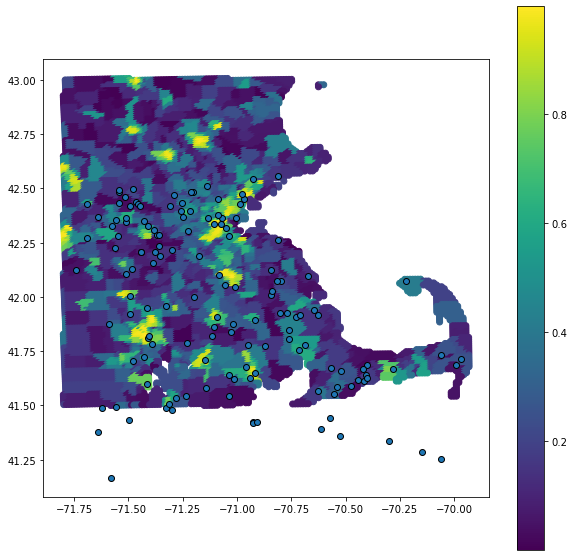

In [15]:
axsvi = airfields.plot(figsize=(10,10), alpha=1, edgecolor='k', zorder = 10) #Plot airfields
game_grid_plot.plot('SVI', ax=axsvi, figsize=(10,10), zorder = 0, legend = True) #Plot Social Vulnerability Index

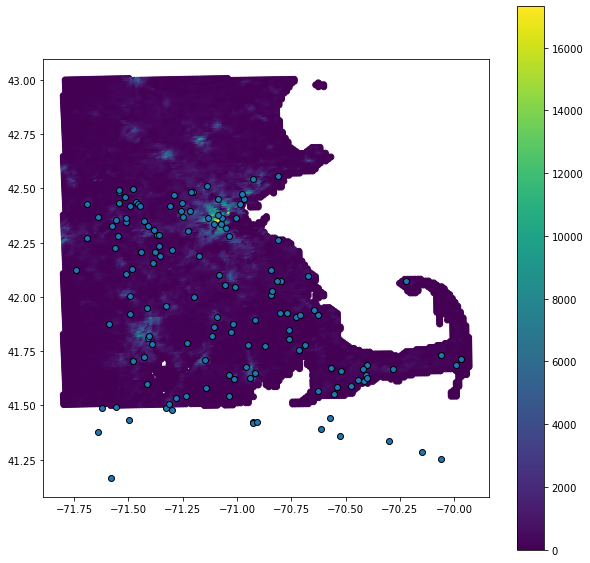

In [16]:
axpop = airfields.plot(figsize=(10,10), alpha=1, edgecolor='k', zorder = 10) #Plot airfields
game_grid_plot.plot('population', ax=axpop, figsize=(10,10), zorder = 0, legend = True) #Plot Population 

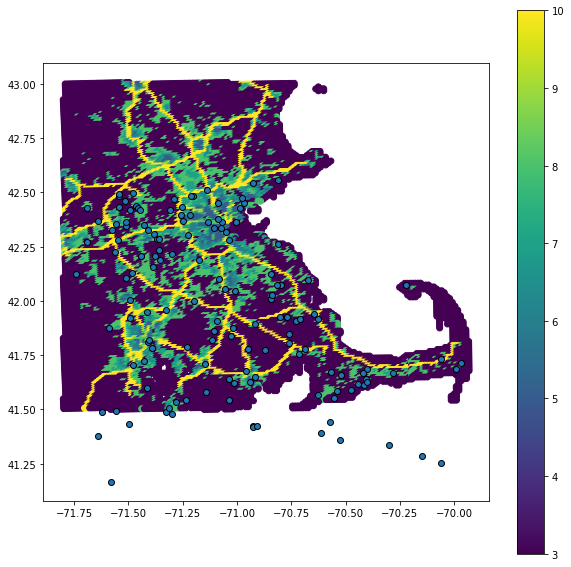

In [17]:
axtrans = airfields.plot(figsize=(10,10), alpha=1, edgecolor='k', zorder = 10) #Plot airfields
game_grid_plot.plot('Transport', ax=axtrans, figsize=(10,10), zorder = 0, legend = True) #Plot Transport 

In [72]:
game_grid = game_grid_plot.copy()
game_grid.crs = 'epsg:3857' #set crs
game_grid = game_grid.to_crs('epsg:4269') #reproject
game_grid

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry
0,19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,10,7,3,15.0,0.2113,POINT (-0.00064 0.00039)
1,19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,10,7,3,11.0,0.2113,POINT (-0.00064 0.00039)
2,19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,10,7,3,14.0,0.2113,POINT (-0.00064 0.00039)
3,19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,10,7,3,21.0,0.2113,POINT (-0.00064 0.00039)
4,19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,10,7,3,28.0,0.0336,POINT (-0.00064 0.00039)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,10,5,3,0.0,0.0495,POINT (-0.00063 0.00037)
15886,19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,10,5,3,0.0,0.0495,POINT (-0.00063 0.00037)
15887,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,10,5,3,0.0,0.0495,POINT (-0.00063 0.00037)
15888,19TDF1699,DF,19T,416000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.001099,41.542803,10,5,3,0.0,0.0495,POINT (-0.00063 0.00037)


In [60]:
new_airfields = gpd.sjoin(game_grid, airfields.to_crs('epsg:4269'), how="inner", op='contains') #spatial join game_grid and airfields
new_airfields

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,...,Utility,Transport,population,SVI,geometry,index_right,objectid,facilityty,stateabbv,city


In [49]:
### Game grid to network conversion

In [61]:
import networkx as nx
import pandas as pd

In [62]:
game_grid = game_grid.to_crs('epsg:4269') # convert geometry to latitude, longitude to match centroid location
game_grid['EAST'] = pd.to_numeric(game_grid['EASTING'].str[:-5]) # calculate grid east position from easting and ignore trailing 000mE
game_grid['NORTH'] = pd.to_numeric(game_grid['NORTHING'].str[:-5]) # calculate grid north position from northing and ignore trailing 000mN
game_grid_pos = game_grid.set_index(['EAST', 'NORTH']) # set index to grid position for seperate dataframe
game_grid = game_grid.set_index('MGRS') # use MGRS as main indexing method

In [63]:
%%timeit -r 1 global G # time entire cell to show performance
G = nx.Graph() # create empty networkx graph
for pos, cell in game_grid_pos.iterrows():
    for neighbor_pos in [(pos[0]+1, pos[1]), # east
                         (pos[0]-1, pos[1]), # west
                         (pos[0],   pos[1]+1), # north
                         (pos[0],   pos[1]-1)]: # south
        if neighbor_pos in game_grid_pos.index:
            neighbor = game_grid_pos.loc[neighbor_pos] # find neighbor in this direction
            G.add_edge(cell['MGRS'], # cell MGRS id, used as node id
                       neighbor['MGRS'], # neighbor MGRS id, used as node id
                       weight = (1/cell['Transport'] + 1/neighbor['Transport']) * 5/2) # weight from definition

24.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [64]:
nx.set_node_attributes(G, game_grid.to_dict('index')) # use pandas dataframe for node data

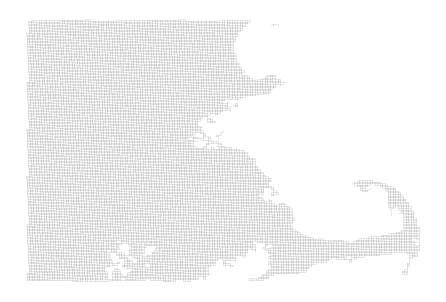

In [65]:
nx.draw(G,
        game_grid[['x_centroid', 'y_centroid']].T.to_dict('list'), # use centroids for positions
        node_size = 0, # hide nodes
        width = 0.1) # show thin edges


In [66]:
### Vehicle Routing Problem

In [67]:
# calculate basic flood risk heuristic based on distance to two coastline points
game_grid['FLOOD_RISK']=-np.minimum(np.sqrt((game_grid['x_centroid']+70.3)**2+(game_grid['y_centroid']-42.2)**2),
                                    np.sqrt((game_grid['x_centroid']+70.2)**2+(game_grid['y_centroid']-41.4)**2))
game_grid['FLOOD_RISK']-=np.min(game_grid['FLOOD_RISK'])
game_grid['FLOOD_RISK']/=np.max(game_grid['FLOOD_RISK'])

In [68]:
# calculate risk based upon flood risk and SVI (Social Vulnerability Index)
game_grid['RISK']=game_grid['SVI']*(game_grid['FLOOD_RISK'])*0.9+0.1

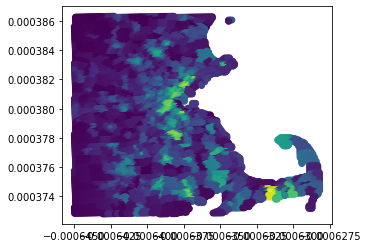

In [69]:
game_grid.plot('RISK')

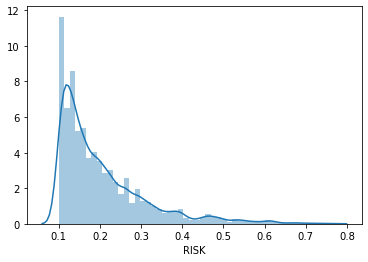

In [70]:
import seaborn as sns
sns.distplot(game_grid['RISK'])

In [73]:
game_grid = game_grid.to_crs('epsg:4269') # convert geometry to latitude, longitude to match centroid location
game_grid['EAST'] = pd.to_numeric(game_grid['EASTING'].str[:-5]) # calculate grid east position from easting and ignore trailing 000mE
game_grid['NORTH'] = pd.to_numeric(game_grid['NORTHING'].str[:-5]) # calculate grid north position from northing and ignore trailing 000mN
game_grid_pos = game_grid.set_index(['EAST', 'NORTH']) # set index to grid position for seperate dataframe
game_grid = game_grid.set_index('MGRS') # use MGRS as main indexing method

In [74]:
%%timeit -r 1 global G # time entire cell to show performance
# create a graph from GeoDataFrame connected as a grid
G = nx.Graph() # create empty networkx graph
for pos, cell in game_grid_pos.iterrows():
    for neighbor_pos in [(pos[0]+1, pos[1]), # east
                         (pos[0]-1, pos[1]), # west
                         (pos[0],   pos[1]+1), # north
                         (pos[0],   pos[1]-1)]: # south
        if neighbor_pos in game_grid_pos.index:
            neighbor = game_grid_pos.loc[neighbor_pos] # find neighbor in this direction
            G.add_edge(cell['MGRS'], # cell MGRS id, used as node id
                       neighbor['MGRS'], # neightbor MGRS id, used as node id
                       weight = (1/cell['Transport'] + 1/neighbor['Transport']) * 5/2) # weight from definition

24.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [75]:
nx.set_node_attributes(G, game_grid.to_dict('index')) # use pandas DataFrame for node data

In [76]:
bases = ('19TCG1685','19TCG1752') # choose two bases for routes

In [105]:
positions=game_grid[['x_centroid', 'y_centroid']].T.to_dict('list') # positions of nodes to plot

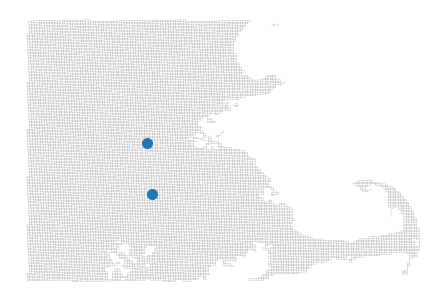

In [106]:
import matplotlib. pyplot as plt

# draw networkx graph
# first draw edges
ax=nx.draw(G,
        positions, # use centroids for positions
        width = 0.1,
        node_size=0) # show thin edges
# then draw base nodes
nx.draw_networkx_nodes(G,
        positions, # use centroids for positions
        node_size = 100,
        nodelist = bases, # only showing bases 
        ax=ax)
plt.savefig('base_locations.svg', bbox_inches='tight')

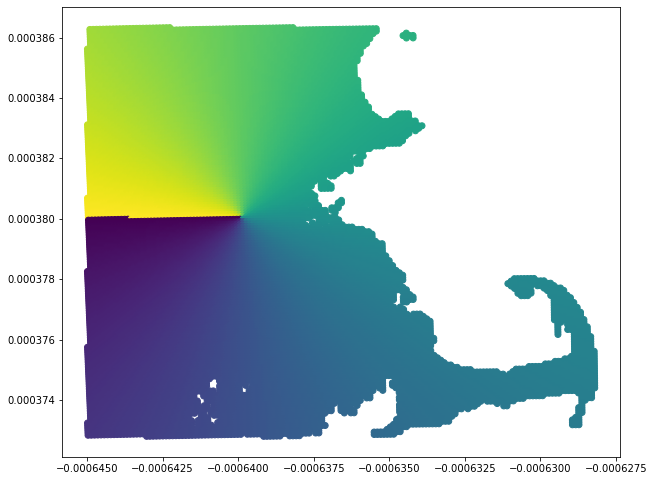

In [107]:
# save angle from first base to cell
game_grid['THETA'] = np.arctan2(game_grid['y_centroid']-game_grid.loc[bases[0],'y_centroid'],
                                game_grid['x_centroid']-game_grid.loc[bases[0],'x_centroid'])
game_grid.plot('THETA',figsize=(10,10))
plt.savefig('cell_angles.svg', bbox_inches='tight')

In [108]:
# save distance from first base to cell
game_grid['DISTANCE'] = pd.Series(nx.single_source_shortest_path_length(G,bases[0]))

In [109]:
# load shelters location from file and convert to same CRS as game_grid
shelters=gpd.read_file('facilities/shelters.shp').to_crs('epsg:4269')
# convert shelters to cell locations
shelters_gdf=gpd.sjoin(game_grid,shelters,how='inner',op='contains')

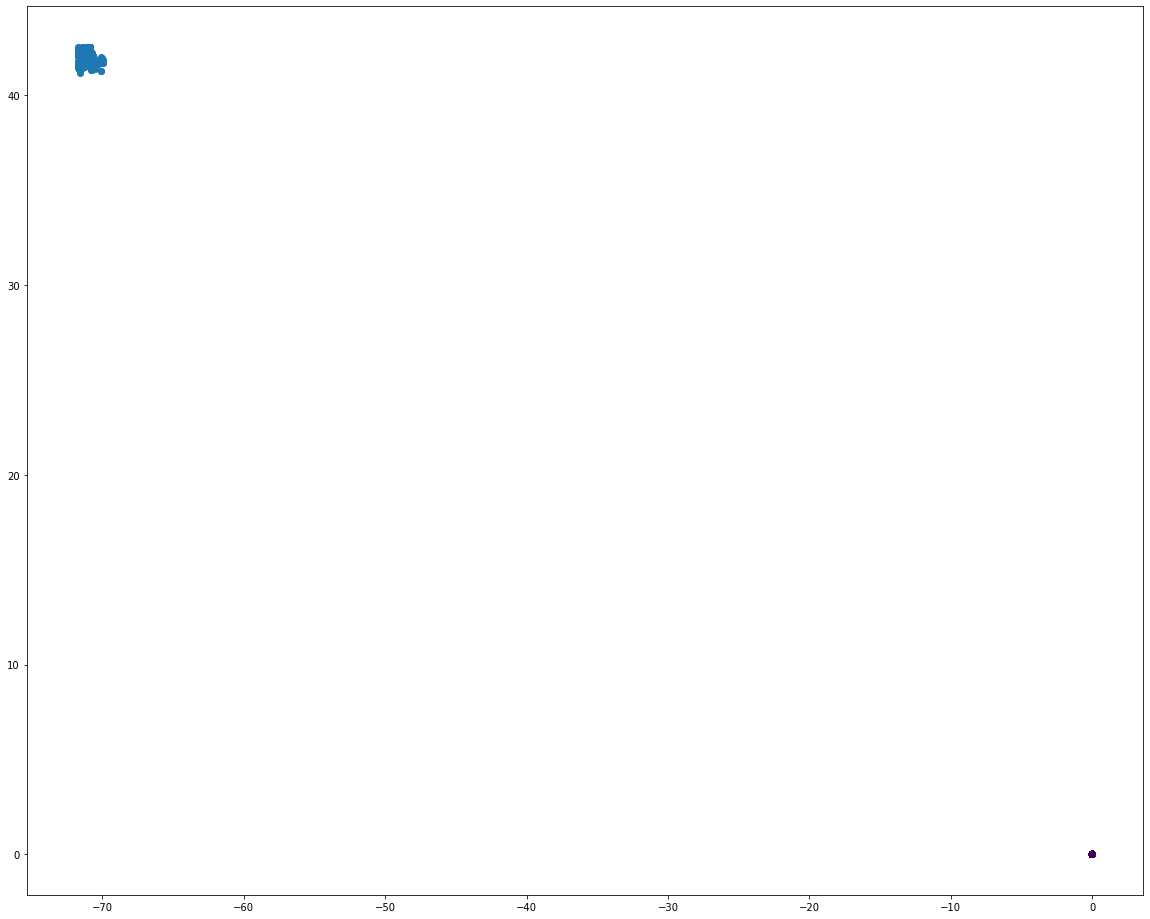

In [110]:
ax=game_grid.plot('Transport',figsize=(20,20))
shelters.plot(figsize=(20,20),ax=ax)
plt.savefig('shelter_locations.svg', bbox_inches='tight')

In [111]:
from tqdm import tqdm

def shortestPathNetwork(nodeList, ogNetwork):
    shortest_path_matrix = np.zeros([len(nodeList),len(nodeList)])
    for idx_i, orig in enumerate(tqdm(nodeList)):
        shortest_paths = nx.single_source_dijkstra_path_length(ogNetwork, orig, weight='weight')
        for idx_j, dest in enumerate(nodeList):
            shortest_path_matrix[idx_i, idx_j] = shortest_paths[dest]
    smallGraph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)
    smallGraph = nx.relabel_nodes(smallGraph,{k:v for k, v in zip(smallGraph.nodes, nodeList)})
    return smallGraph

In [112]:
graph_nodes=list(shelters_gdf.index)+list(bases)

In [113]:
graph=shortestPathNetwork(graph_nodes,G)

100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


In [114]:
H = nx.DiGraph(graph.to_directed())

In [115]:
for node in H.nodes:
    H.nodes[node]['demand']=1
    H.nodes[node]['time']=20
    H.nodes[node]['service_time']=24*60

In [116]:
for edge in H.edges:
    weight=H[edge[0]][edge[1]]['weight']
    H[edge[0]][edge[1]]['cost']=[weight,weight*1.2]
    H[edge[0]][edge[1]]['time']=weight*1.2

In [117]:
H=nx.relabel_nodes(H,{bases[0]:'Source',bases[1]:'Sink'})

In [118]:
H.remove_edges_from(list(H.in_edges('Source')))
H.remove_edges_from(list(H.out_edges('Sink')))

In [119]:
prob = VehicleRoutingProblem(H, mixed_fleet=True, load_capacity=[3,20], fixed_cost=[20,40], num_vehicles=[20,20], drop_penalty=500)
prob.solve(exact=False,time_limit=60)

INFO:vrpy.main:new upper bound : max num stops = 2
/opt/conda/lib/python3.7/site-packages/pulp/apis/coin_api.py:61: UserWarning: Parameter maxSeconds is being depreciated for standard 'timeLimit'
  warnings.warn("Parameter maxSeconds is being depreciated for standard 'timeLimit'")
INFO:vrpy.main:iteration 0, 0.0


ValueError: max() arg is an empty sequence

In [102]:
print(prob.best_value)


AttributeError: 'VehicleRoutingProblem' object has no attribute '_dropped_nodes'

In [103]:
edges=[]
for route in prob.best_routes.values():
    edges+=list(zip(route,np.roll(route,1)))

AttributeError: 'VehicleRoutingProblem' object has no attribute '_best_routes'

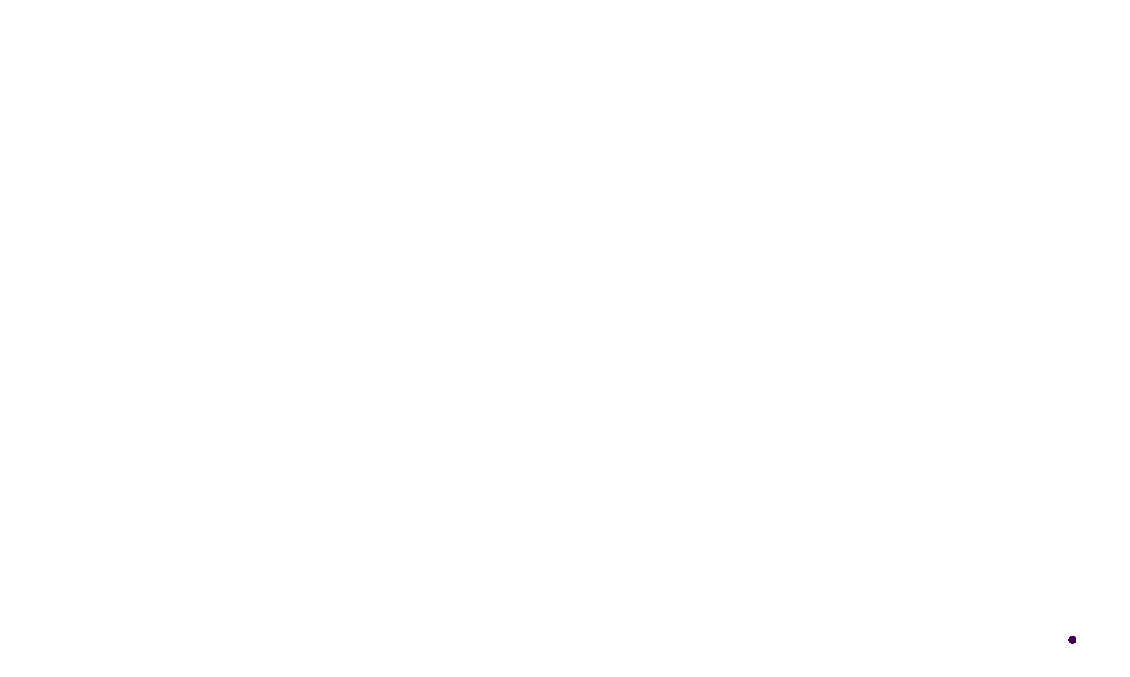

In [104]:
pos=game_grid[['x_centroid','y_centroid']].T.to_dict('list')
pos['Source'] = pos.pop(bases[0])
pos['Sink'] = pos.pop(bases[1])
ax=game_grid.plot('Transport',figsize=(20,20),alpha=0.5)
nx.draw(H,pos=pos,edgelist=edges,node_size=0,width=1,ax=ax)
plt.savefig('paths.svg', bbox_inches='tight')

# Public Information
The Public Information team is the face of the response. Your job is to synthesize the information from each of the respective teams and communicate it to the general public in a succinct and easily understood manner. Present all of this information as if it were part of a real response scenario.

## Team Briefings
For each of the three other teams, put together a 5-10 minute video documenting:
- The team's tasks
- What approaches and tools they are using
- What challenges are they facing
- How are they addressing the challenges
- Why are they making the decisions they are
- What are the potential impacts of their decisions
We recommend that you have one member of the Public Information team embed themselves in each of the other teams as their representative

## Final Briefing
On the day of the final exercise, the Public Information team is in charge of putting together a 1.5-hour press conference documenting the entire final exercise. Present the exercise as a narrative, starting with the planning phase, the event, the response, and the results. Bring in representatives from each of the respective teams to speak on their components of the exercise.

Be sure to create graphics and illustrations to explain the entire process and scenario.